## Question 3
Author: ruhei08
__________
2) Investigate if your model’s performance is particularly good or bad at correctly classifying certain classes (i.e., it might be very good at correctly classifying centuries but not years, or it might be good at correctly classifying some decades but not certain other decades). Does it mix up certain classes? If yes, does this surprise you (explain why or why not)?

## Loading the Models
_______
We will investigate the performance of the ResNet inspired models. We rebuild the models and load the weights.

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, SpatialDropout2D, Input, BatchNormalization, Add, Flatten
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomTranslation, RandomContrast
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


def build_model(units_out):
    BLOCK_DEPTH = 3
    SPATIAL_DROPOUT_RATE = 0.08
    
    data_augmentation = Sequential([
                    RandomRotation(0.04),
                    RandomContrast(0.1),
                    RandomTranslation(width_factor=0.05, height_factor=0.05),
                ])
    
    inp = Input(shape=(100,150,1))
    x = data_augmentation(inp)
    for filters in [32,64,64,128]:
        x = Conv2D(filters, kernel_size=(3,3), activation="relu", use_bias =False)(x)
        skip = x
        x = BatchNormalization()(x)
        x = SpatialDropout2D(SPATIAL_DROPOUT_RATE)(x)
        for _ in range(BLOCK_DEPTH):
            x = Conv2D(filters, kernel_size=(3,3), activation="relu", use_bias =False, padding="same")(x)
            x = BatchNormalization()(x)
            x = SpatialDropout2D(SPATIAL_DROPOUT_RATE)(x)
        x = Add()([x,skip])
        x = BatchNormalization()(x)
        x = SpatialDropout2D(SPATIAL_DROPOUT_RATE)(x)
        x = MaxPooling2D(pool_size=(2,2))(x)
    x = Flatten()(x)
    x = Dense(128,activation="relu")(x)
    x = Dropout(0.2)(x)
    out = Dense(units_out,activation="softmax")(x)
    return Model(inp, out)

In [2]:
modelCC = build_model(2)

optimizer = Adam(learning_rate = 1e-3)

modelCC.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

modelCC.load_weights("Models/res_CC_w.h5")

2022-01-30 13:46:50.756209: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
modelD = build_model(6)

optimizer = Adam(learning_rate = 1e-3)

modelD.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

modelD.load_weights("Models/res_D.h5")

In [4]:
modelY = build_model(11)

optimizer = Adam(learning_rate = 1e-3)

modelY.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

modelY.load_weights("Models/res_Y.h5")

## Loading the Data
_________

In [5]:
import os
from natsort import natsorted
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd

def image_files():
    # Read filenames of all files in the data directory
    list_files = os.listdir('./DIDA_1')
    # Sort filenames to make sure they are in the same order as the labels
    list_files = natsorted(list_files) 
    return list_files


def load_images(filepaths):
    images = []
    for i in range(len(filepaths)):
        # Resize images to be (100, 150, 1)
        img = image.load_img("DIDA_1/"+filepaths[i], target_size=(100,150,1), color_mode="grayscale")
        img = image.img_to_array(img)
        img.astype('float32')
        # Rescale to make all pixel values between 0 and 1
        img = img/255
        images.append(img)
    images = np.array(images)
    return images


# Loading, resizing and rescaling the images
filepaths = image_files()
X = load_images(filepaths)


# Loading the targets
targets = pd.read_csv('CC_D_Y_labels.csv')
y_cc = targets.CC.to_numpy()
y_d = targets.D.replace(10,5).to_numpy()    # Keras only works if there is no "gap" in the labels
y_y = targets.Y.to_numpy()


## Train/Val/Test Split
________


In [6]:
# Making the same train/val/test split as before ensures we can localise the misclassified images.

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X_train_and_val, X_test, y_train_and_val_cc, y_test_cc, y_train_and_val_d, y_test_d, y_train_and_val_y, y_test_y = train_test_split(X, 
                                                                                                                                    y_cc, 
                                                                                                                                    y_d, 
                                                                                                                                    y_y, 
                                                                                                                                    test_size=0.1, 
                                                                                                                                    shuffle=True, 
                                                                                                                                    stratify=y_cc, 
                                                                                                                                    random_state=42)


X_train, X_val, y_train_cc, y_val_cc, y_train_d, y_val_d, y_train_y, y_val_y = train_test_split(X_train_and_val, 
                                                                                                y_train_and_val_cc, 
                                                                                                y_train_and_val_d, 
                                                                                                y_train_and_val_y, 
                                                                                                test_size=0.2, 
                                                                                                shuffle=True, 
                                                                                                stratify=y_train_and_val_cc, 
                                                                                                random_state=42)


print("Number of training samples:", len(X_train))
print("Number of validation samples:", len(X_val))
print("Number of test samples:", len(X_test))

y_train_cc = to_categorical(y_train_cc)
y_val_cc = to_categorical(y_val_cc)
y_test_cc = to_categorical(y_test_cc)

Number of training samples: 8640
Number of validation samples: 2160
Number of test samples: 1200


## Accuracy
_____


In [7]:
from sklearn.metrics import accuracy_score
import numpy as np

### ModelCC

In [8]:
y_train_hat_cc = modelCC.predict(X_train)
y_train_hat_cc = np.rint(y_train_hat_cc)    # Round predictions to nearest int (0 or 1)
acc_train_cc = accuracy_score(y_train_hat_cc, y_train_cc)

y_val_hat_cc = modelCC.predict(X_val)
y_val_hat_cc = np.rint(y_val_hat_cc)
acc_val_cc = accuracy_score(y_val_hat_cc, y_val_cc)

y_test_hat_cc = modelCC.predict(X_test)
y_test_hat_cc = np.rint(y_test_hat_cc,)
acc_test_cc = accuracy_score(y_test_hat_cc, y_test_cc)

print("ModelCC")
print("Accuracy on training data:", acc_train_cc)
print("Accuracy on validation data:", acc_val_cc)
print("Accuracy on test data:", acc_test_cc)

2022-01-30 13:47:09.647157: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


ModelCC
Accuracy on training data: 0.999537037037037
Accuracy on validation data: 0.9981481481481481
Accuracy on test data: 0.9966666666666667


### ModelD

In [9]:
y_train_hat_d = modelD.predict(X_train)
y_train_hat_d = np.argmax(y_train_hat_d, axis = 1)      # Find the class with highest probability
acc_train_d = accuracy_score(y_train_hat_d, y_train_d)

y_val_hat_d = modelD.predict(X_val)
y_val_hat_d = np.argmax(y_val_hat_d, axis = 1)
acc_val_d = accuracy_score(y_val_hat_d, y_val_d)

y_test_hat_d = modelD.predict(X_test)
y_test_hat_d = np.argmax(y_test_hat_d, axis = 1)
acc_test_d = accuracy_score(y_test_hat_d, y_test_d)

print("ModelD")
print("Accuracy on training data:", acc_train_d)
print("Accuracy on validation data:", acc_val_d)
print("Accuracy on test data:", acc_test_d)

ModelD
Accuracy on training data: 0.9945601851851852
Accuracy on validation data: 0.9851851851851852
Accuracy on test data: 0.9875


### ModelY

In [10]:
y_train_hat_y = modelY.predict(X_train)
y_train_hat_y = np.argmax(y_train_hat_y, axis = 1)
acc_train_y = accuracy_score(y_train_hat_y, y_train_y)

y_val_hat_y = modelY.predict(X_val)
y_val_hat_y = np.argmax(y_val_hat_y, axis = 1)
acc_val_y = accuracy_score(y_val_hat_y, y_val_y)

y_test_hat_y = modelY.predict(X_test)
y_test_hat_y = np.argmax(y_test_hat_y, axis = 1)
acc_test_y = accuracy_score(y_test_hat_y, y_test_y)

print("ModelY")
print("Accuracy on training data:", acc_train_y)
print("Accuracy on validation data:", acc_val_y)
print("Accuracy on test data:", acc_test_y)

ModelY
Accuracy on training data: 0.9913194444444444
Accuracy on validation data: 0.9791666666666666
Accuracy on test data: 0.9783333333333334


## Confusion Matrix
______

In [11]:
# print confusion matrices

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


### ModelCC

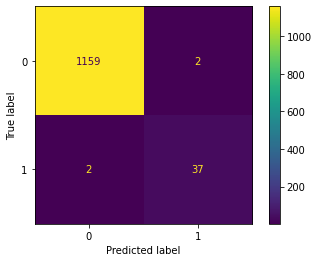

In [12]:
cm_cc = confusion_matrix(np.argmax(y_test_cc, axis=1), np.argmax(y_test_hat_cc, axis=1))

disp_cc = ConfusionMatrixDisplay(confusion_matrix=cm_cc)

disp_cc.plot()

### ModelD

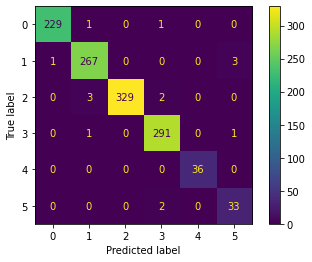

In [13]:
cm_d = confusion_matrix(y_test_d, y_test_hat_d)

disp_d = ConfusionMatrixDisplay(confusion_matrix=cm_d)

disp_d.plot()

### ModelY

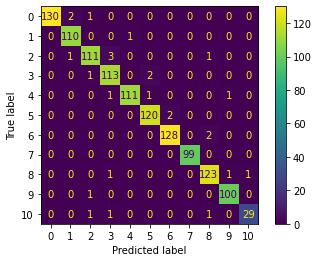

In [14]:
cm_y = confusion_matrix(y_test_y, y_test_hat_y)

disp_y = ConfusionMatrixDisplay(confusion_matrix=cm_y)

disp_y.plot()

## Classification Report
______

In [15]:
## Inspect recall
from sklearn.metrics import classification_report

### ModelCC

In [16]:
print(classification_report(y_test_hat_cc, y_test_cc))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1161
           1       0.95      0.95      0.95        39

   micro avg       1.00      1.00      1.00      1200
   macro avg       0.97      0.97      0.97      1200
weighted avg       1.00      1.00      1.00      1200
 samples avg       1.00      1.00      1.00      1200



### ModelD

In [17]:
print(classification_report(y_test_hat_d, y_test_d))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       230
           1       0.99      0.98      0.98       272
           2       0.99      1.00      0.99       329
           3       0.99      0.98      0.99       296
           4       1.00      1.00      1.00        36
           5       0.94      0.89      0.92        37

    accuracy                           0.99      1200
   macro avg       0.98      0.98      0.98      1200
weighted avg       0.99      0.99      0.99      1200



### ModelY

In [18]:
print(classification_report(y_test_hat_y, y_test_y))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       130
           1       0.99      0.97      0.98       113
           2       0.96      0.97      0.96       115
           3       0.97      0.95      0.96       119
           4       0.97      0.99      0.98       112
           5       0.98      0.98      0.98       123
           6       0.98      0.98      0.98       130
           7       1.00      1.00      1.00        99
           8       0.98      0.97      0.97       127
           9       0.99      0.98      0.99       102
          10       0.91      0.97      0.94        30

    accuracy                           0.98      1200
   macro avg       0.97      0.98      0.98      1200
weighted avg       0.98      0.98      0.98      1200



## A Look at Misclassified Images
______

### ModelCC

700
703
802
1050
Number of misclassifications for modelCC: 4


/var/folders/9b/k_h6ngpx3kv367vts9rx99nh0000gn/T/ipykernel_4863/73540722.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


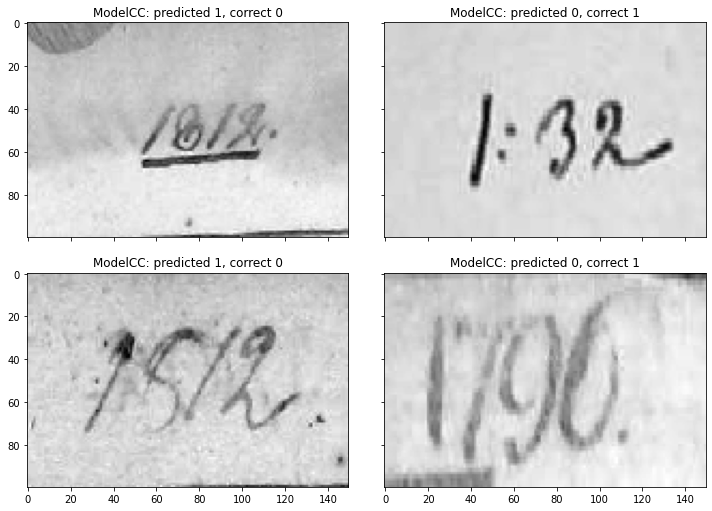

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

ytcc = np.argmax(y_test_cc, axis=1)
ythcc = np.argmax(y_test_hat_cc, axis=1)

count = 0
images = []
titles = []
for i in range(len(y_test_cc)):
    if ytcc[i] != ythcc[i]:
        print(i)
        count = count + 1
        images.append(X_test[i])
        titles.append(f"ModelCC: predicted {ythcc[i]}, correct {ytcc[i]}")


print("Number of misclassifications for modelCC:", count)


fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 4x4 grid of axes
                 axes_pad=0.5,  # pad between axes in inch.
                 )

for ax, im, ti in zip(grid, images, titles):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap='gray')
    ax.set_title(ti)


plt.tight_layout()
plt.show()

### ModelD

Number of misclassifications for modelD: 15


/var/folders/9b/k_h6ngpx3kv367vts9rx99nh0000gn/T/ipykernel_4863/2461841704.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


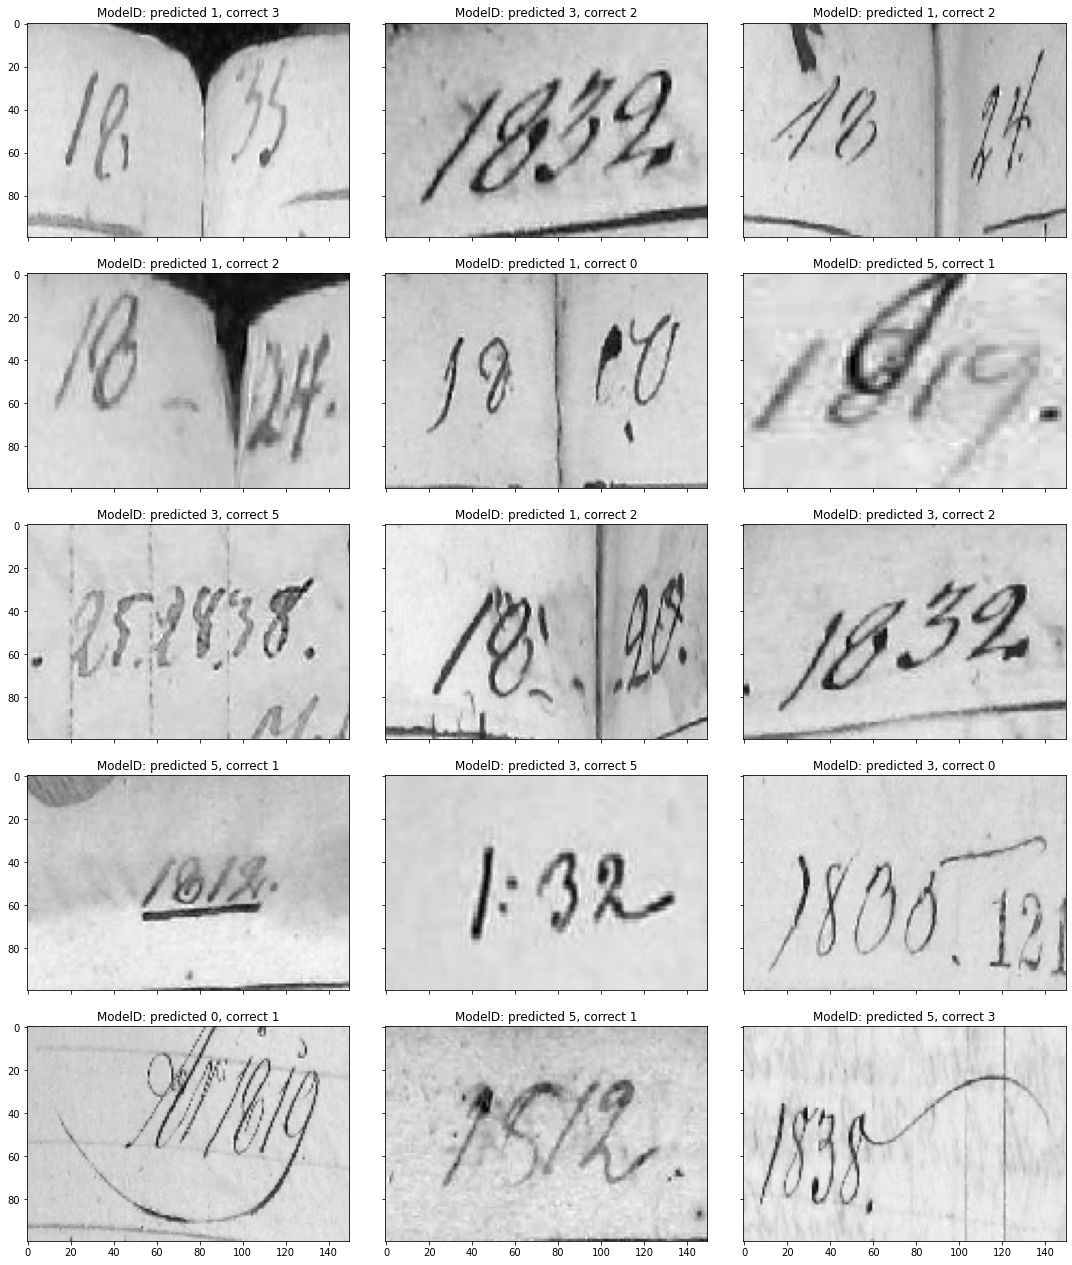

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np


count = 0
images = []
titles = []
for i in range(len(y_test_d)):
    if y_test_d[i] != y_test_hat_d[i]:
        count = count + 1
        images.append(X_test[i])
        titles.append(f"ModelD: predicted {int(y_test_hat_d[i])}, correct {y_test_d[i]}")


print("Number of misclassifications for modelD:", count)


fig = plt.figure(figsize=(15, 21))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(5, 3),  # creates 4x4 grid of axes
                 axes_pad=0.5,  # pad between axes in inch.
                 )

for ax, im, ti in zip(grid, images, titles):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap='gray')
    ax.set_title(ti)

plt.tight_layout()
plt.show()

### ModelY

Number of misclassifications for modelY: 26


/var/folders/9b/k_h6ngpx3kv367vts9rx99nh0000gn/T/ipykernel_4863/217191316.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


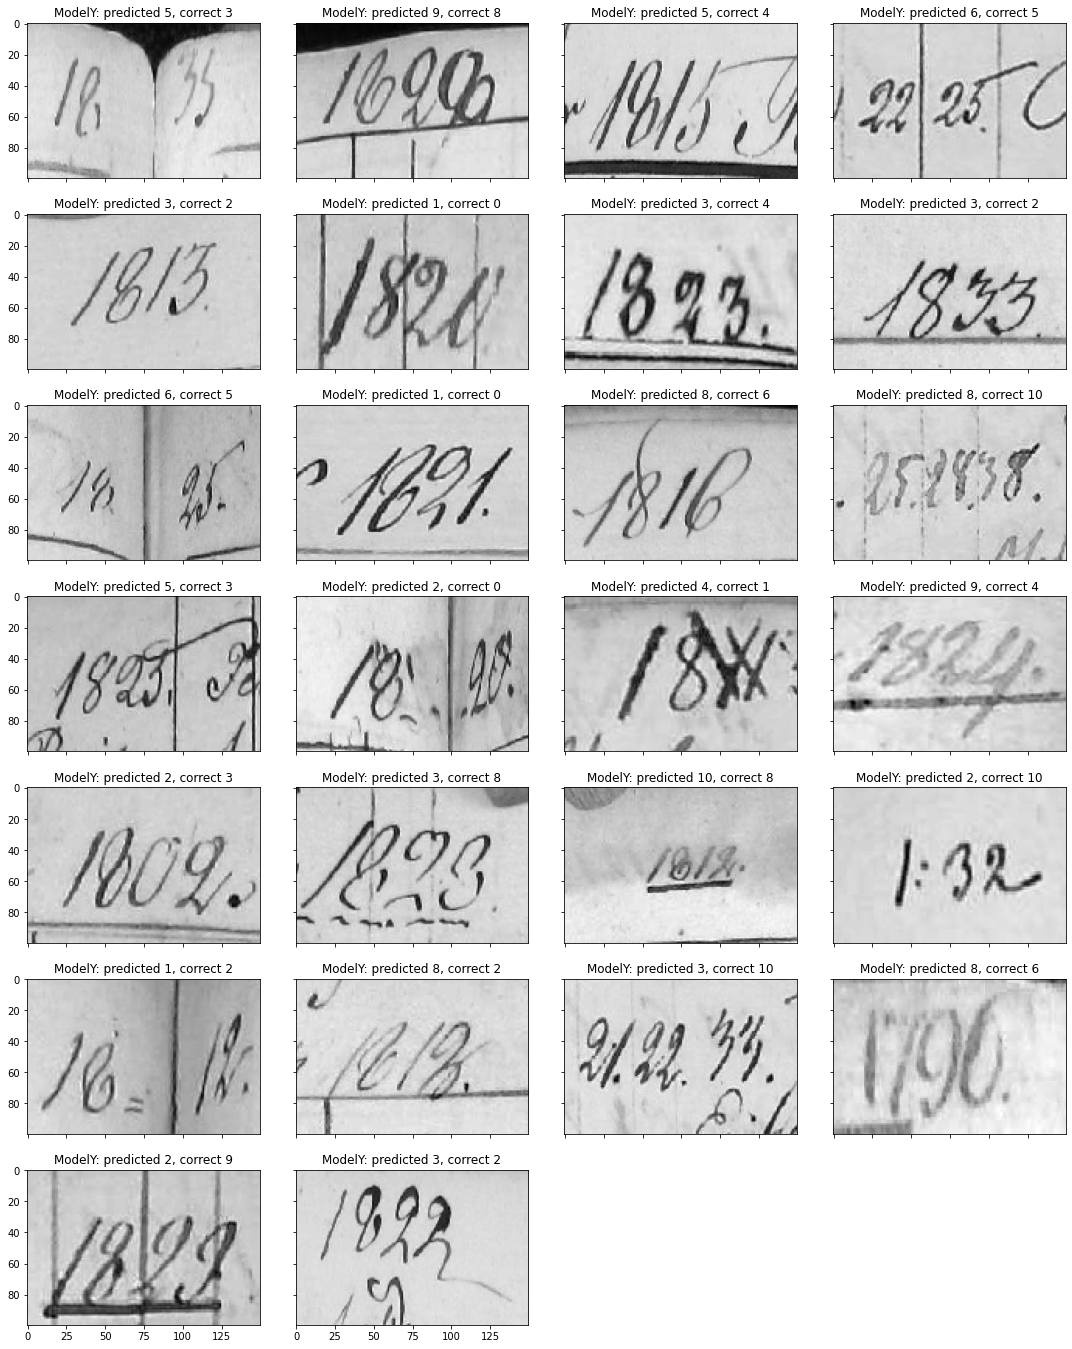

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np


count = 0
images = []
titles = []
for i in range(len(y_test_y)):
    if y_test_y[i] != y_test_hat_y[i]:
        count = count + 1
        images.append(X_test[i])
        titles.append(f"ModelY: predicted {int(y_test_hat_y[i])}, correct {y_test_y[i]}")


print("Number of misclassifications for modelY:", count)


fig = plt.figure(figsize=(15, 21))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(7, 4),  # creates 4x4 grid of axes
                 axes_pad=0.5,  # pad between axes in inch.
                 )

for ax, im, ti in zip(grid, images, titles):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap='gray')
    ax.set_title(ti)
grid[-2].axis("off")
grid[-1].axis("off")
plt.tight_layout()
plt.show()